# MPS and MNIST

This tutorial aims to implement MPS algorithm in the analysis of the standard MNIST experiment. We start with the typical headers importing pytorch utilities and its MPS implementation

In [1]:
import time
import torch
from torchmps import MPS
from torchvision import transforms, datasets

1 `time`: Python has a module named time to handle time-related tasks. 

2 `torch`: Backend with utilities in ML

3 `TorchMPS`: TorchMPS is a framework for working with matrix product state (also known as MPS or tensor train) models within Pytorch. Our MPS models are written as Pytorch Modules, and can simply be viewed as differentiable black boxes that are interchangeable with standard neural network layers. However, the rich structure of MPS's allows for more interesting behavior, such as: 

* A novel adaptive training algorithm (inspired by Stoudenmire and Schwab 2016), which dynamically varies the MPS hyperparameters (MPS bond dimensions) during the course of training.

* Mechanisms for controlling MPS geometry, such as custom "routing" of the MPS through different regions of the input data, or periodic boundary conditions that give the MPS a circular topology.

* Choice of tensor contraction strategies, which represent flexible tradeoffs between computational cost and parallelizability of the computation graph.


4 `torchvision`: This package consists of popular datasets, model architectures, and common image transformations for computer vision.

In [2]:
# esthetic definitions for the plots
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}

import matplotlib.pyplot as plt # for plotting

We need to plot our results. For this result we will use matplotlib properties.

In [3]:
# Miscellaneous initialization
torch.manual_seed(0)
start_time = time.time()

Now we will be hands on!. 

1 `torch.manual_seed(0)`: manual_seed sets the random seed from pytorch random number generators

2 `time.time()`: The time() function returns the number of seconds passed since epoch.

In [4]:
# MPS parameters

bond_dim      = 20
adaptive_mode = False
periodic_bc   = False

These ones behave as parameters in the algorithm.

* `bond_dim`: The internal bond dimension, a hyperparameter that sets the expressivity of our MPS. When in adaptive training mode, bond_dim instead sets the maximum possible bond dimension, with the initial bond dimension equal to output_dim.      
* `adaptive_mode`: Whether our MPS is trained with its bond dimensions chosen adaptively or are fixed at creation (default = False (fixed bonds)). 
* `periodic_bc`: Whether our MPS has periodic boundary conditions (making it a tensor ring) or open boundary conditions (default = False (open boundaries)).   

In [5]:
# Training parameters
num_train  = 2000
num_test   = 1000
batch_size = 100
num_epochs = 20
learn_rate = 1e-4
l2_reg     = 0.

* `num_train`: Number of samples for training.
* `num_test`:  Number of samples for testing.
* `batch_size`: The batch size defines the number of samples that will be propagated through the architecture. 
* `num_epochs`: One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. 
* `learn_rate`: The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.  
* `l2_reg`:   When training neural networks, it is common to use "weight decay," where after each update, the weights are multiplied by a factor slightly less than 1. This prevents the weights from growing too large, and can be seen as gradient descent on a quadratic regularization term. 

In [6]:
# Initialize the MPS module
mps = MPS(input_dim=28**2, output_dim=10, bond_dim=bond_dim, 
          adaptive_mode=adaptive_mode, periodic_bc=periodic_bc)

* `input_dim`: The dimension of the input we feed to our MPS
* `output_dim`: The dimension of the output we get from each input

In [7]:
# Set our loss function and optimizer
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mps.parameters(), lr=learn_rate, weight_decay=l2_reg)

* `Cross_EntropyLoss() `: Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

* `Adam.optimizer`: Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
Adam combines the advantages of two other extensions of stochastic gradient descent. Specifically:

* Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

* Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

In [8]:
# Get the training and test sets
transform = transforms.ToTensor()
train_set = datasets.MNIST('./mnist', download=True, transform=transform)
test_set = datasets.MNIST('./mnist', download=True, transform=transform,train=False)

* `transforms.ToTensor()`: This just converts your input image to PyTorch tensor.
A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type.



In [9]:
# Put MNIST data into dataloaders
samplers = {'train': torch.utils.data.SubsetRandomSampler(range(num_train)),
            'test': torch.utils.data.SubsetRandomSampler(range(num_test))}
loaders = {name: torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
           sampler=samplers[name], drop_last=True) for (name, dataset) in 
           [('train', train_set), ('test', test_set)]}
num_batches = {name: total_num // batch_size for (name, total_num) in
               [('train', num_train), ('test', num_test)]}

* `torch.utils.data.SubsetRandomSampler()`: Samples elements randomly from a given list of indices, without replacement.

* `torch.utils.data.DataLoader`: Combines a dataset and a sampler, and provides an iterable over the given dataset.

In [10]:
print(f"Training on {num_train} MNIST images \n"
      f"(testing on {num_test}) for {num_epochs} epochs")
print(f"Maximum MPS bond dimension = {bond_dim}")
print(f" * {'Adaptive' if adaptive_mode else 'Fixed'} bond dimensions")
print(f" * {'Periodic' if periodic_bc else 'Open'} boundary conditions")
print(f"Using Adam w/ learning rate = {learn_rate:.1e}")
if l2_reg > 0:
    print(f" * L2 regularization = {l2_reg:.2e}")

Training on 2000 MNIST images 
(testing on 1000) for 20 epochs
Maximum MPS bond dimension = 20
 * Fixed bond dimensions
 * Open boundary conditions
Using Adam w/ learning rate = 1.0e-04


## Training

Now, we start with MPS training!

In [11]:
# Let's start training!
iters  = []
losses = []
accur_train = []
accur_test  = []

for epoch_num in range(1, num_epochs+1):
    running_loss = 0.
    running_acc = 0.

    for inputs, labels in loaders['train']:
        inputs, labels = inputs.view([batch_size, 28**2]), labels.data

        # Call our MPS to get logit scores and predictions
        scores = mps(inputs)
        _, preds = torch.max(scores, 1)

        # Compute the loss and accuracy, add them to the running totals
        loss = loss_fun(scores, labels)
        with torch.no_grad():
            accuracy = torch.sum(preds == labels).item() / batch_size
            running_loss += loss
            running_acc += accuracy
            
            
        # Backpropagate and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    accur_train.append(running_acc/num_batches['train'])          
    print(f"### Epoch {epoch_num} ###")
    print(f"Average loss:           {running_loss / num_batches['train']:.4f}")
    print(f"Average train accuracy: {running_acc / num_batches['train']:.4f}")
    
    # Evaluate accuracy of MPS classifier on the test set
    with torch.no_grad():
        running_acc = 0.

        for inputs, labels in loaders['test']:
            inputs, labels = inputs.view([batch_size, 28**2]), labels.data

            # Call our MPS to get logit scores and predictions
            scores = mps(inputs)
            _, preds = torch.max(scores, 1)
            running_acc += torch.sum(preds == labels).item() / batch_size
             
          
    iters.append(epoch_num)
    losses.append(running_loss/batch_size)
    accur_test.append(running_acc/num_batches['test'])
          
    print(f"Test accuracy:          {running_acc / num_batches['test']:.4f}")
    print(f"Runtime so far:         {int(time.time()-start_time)} sec\n")


### Epoch 1 ###
Average loss:           2.2725
Average train accuracy: 0.1380
Test accuracy:          0.1570
Runtime so far:         53 sec

### Epoch 2 ###
Average loss:           1.7856
Average train accuracy: 0.3255
Test accuracy:          0.4630
Runtime so far:         92 sec

### Epoch 3 ###
Average loss:           1.1898
Average train accuracy: 0.6135
Test accuracy:          0.6560
Runtime so far:         135 sec

### Epoch 4 ###
Average loss:           0.7045
Average train accuracy: 0.7735
Test accuracy:          0.7750
Runtime so far:         178 sec

### Epoch 5 ###
Average loss:           0.4400
Average train accuracy: 0.8705
Test accuracy:          0.8120
Runtime so far:         225 sec

### Epoch 6 ###
Average loss:           0.3513
Average train accuracy: 0.9010
Test accuracy:          0.8360
Runtime so far:         270 sec

### Epoch 7 ###
Average loss:           0.2673
Average train accuracy: 0.9145
Test accuracy:          0.8590
Runtime so far:         317 sec

### Epoc

## Loss and accuracy Plot

Plot loss and accuracy outcomes of our training. First, we define ethetics of the plots.

In [12]:
title_font = {'fontname':'serif', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'serif', 'size':'18'}

### Loss

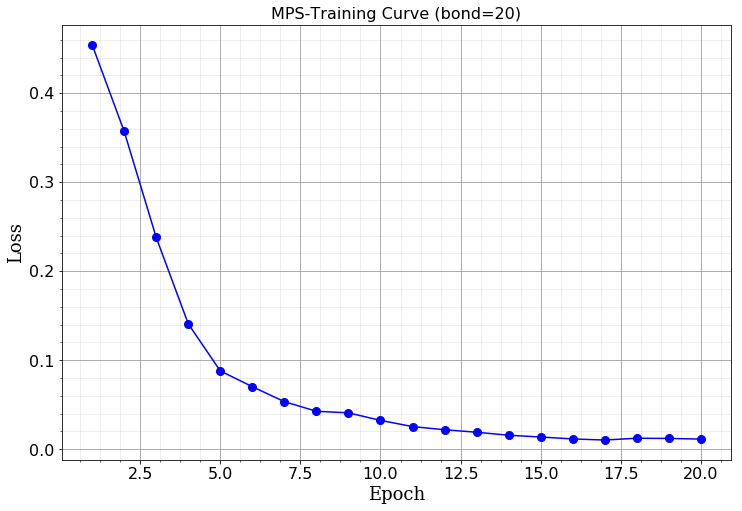

In [28]:
plt.figure(figsize=(12,8))
plt.plot(iters, losses,marker='o', markerfacecolor='blue', markersize=8, color='blue',label='train')
plt.title("MPS-Training Curve (bond={})".format(bond_dim), fontsize=16,)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.ylabel('Loss',**axis_font)
plt.xlabel('Epoch',**axis_font)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()          

### Accuracy

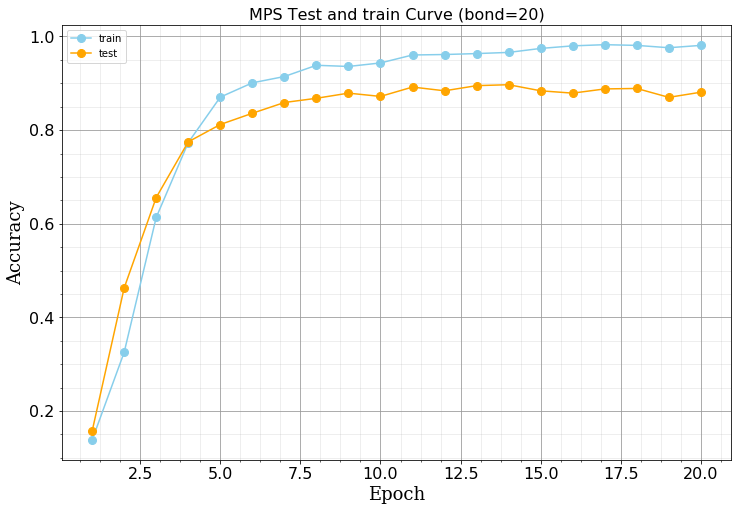

In [27]:
plt.figure(figsize=(12,8))
plt.plot(iters, accur_train,marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue',label='train')
plt.plot(iters, accur_test,marker='o', markerfacecolor='orange', markersize=8, color='orange',label='test')
plt.legend()
plt.title("MPS Test and train Curve (bond={})".format(bond_dim), fontsize=16)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.ylabel('Accuracy',**axis_font)
plt.xlabel('Epoch',**axis_font)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.grid(b=True, which='major', color='#999999', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()          